# Bubble Correlations

In [1]:
import numpy as np
import math
import statistics as stat
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
from itertools import cycle
import random
from numpy import load
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import ticker
from collections import OrderedDict
import matplotlib.colors as mcolors
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

splitdata  [    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000]
lenLat =  2795.084971874737
dx, dk, spec  0.6823937919616058 0.0022479407139330324 2049
dtout/dt =  16.0
light_cone =  2
units =  2.0
threhsolds:  [4.454971420635487, 4.556538858776825, 4.658106296918165]


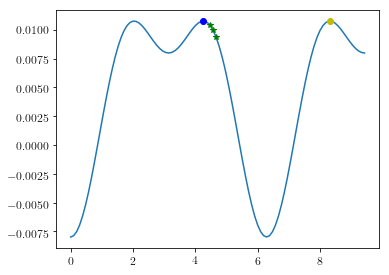

In [3]:
nTime = 256
nLat = 4096
lSim = 0
nSims = 20000
stepSim = 1000
splitdata = np.arange(lSim, nSims+1, stepSim); print('splitdata ', splitdata)

filter_size = 10.
temp = 3#2.5
phi0 = 2.5*np.pi
lamb = 1.5

nu = 2.*10**(-3)
V0 = 4.*nu
m2eff = lambda lam: V0 * (- 1. + lam**2)
lenLat = 250. / np.sqrt(V0); print('lenLat = ', lenLat)
phi_initial = np.pi

nyq = nLat//2+1; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 8.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)
unit_conv = nLat/nTime/alpha; print('units = ', unit_conv)

tcheck = lambda ignore, lam: ignore/np.sqrt(m2eff(lam))/dtout
tTime = lambda ignore, lam: int(nTime - tcheck(ignore, lam))

V = lambda phi, lam: V0 * (-np.cos(phi)+0.5*lam**2.*np.sin(phi)**2.)
dV = lambda phi, lam: V0 * (np.sin(phi)+0.5*lam**2.*np.sin(2.*phi))

far_right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[2*np.pi, 3*np.pi], method='bounded')
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[np.pi, 2*np.pi], method='bounded')
#left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[0, np.pi], method='bounded')
#phi_upper_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 5)[0]; print(phi_upper_bound)
#phi_lower_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 1)[0]; print(phi_lower_bound)

list_multiplier = [0.1, 0.15, 0.2]
list_threshold= [right_phi_at_V_max.x + np.abs(right_phi_at_V_max.x-2*phi_initial)*multiplier for multiplier in list_multiplier]; print('threhsolds: ', list_threshold)

plt.plot(np.linspace(0, 3*np.pi, 100), V(np.linspace(0, 3*np.pi, 100), lamb))
#plt.plot(phi_upper_bound, V(phi_upper_bound, lamb), 'ro', phi_lower_bound, V(phi_lower_bound, lamb), 'go', left_phi_at_V_max.x, V(left_phi_at_V_max.x, lamb), 'ko')
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x, lamb), 'bo', far_right_phi_at_V_max.x, V(far_right_phi_at_V_max.x, lamb), 'yo')
plt.plot(list_threshold, V(list_threshold, lamb), 'g*')

list_type = ['++', '--', '++--', '+-', '-+']
thcorr = ['++', 'foo', '++--', '+-', 'foo']
list_data_plot = [0, 2, 1]
list_title_type = [r'$\xi^{++}_{bb}(t,r)$', r'$\xi^{--}_{bb}(t,r)$', r'$\xi^{overall}_{bb}(t,r)$', r'$\xi^{+-}_{bb}(t,r)$', r'$\xi^{-+}_{bb}(t,r)$']

Rrange = lambda minx, maxx, stepx: np.arange(minx, maxx+1, stepx)
Trange = lambda minx, maxx, stepx: np.arange(minx, maxx+1, stepx)

list_phi0 = [phi0]
list_lamb = [lamb]
list_temp = [temp]

### Theoretical PS

In [4]:
norm = lambda phi: 1./ phi / np.sqrt(lenLat)
freqs = dk * np.asarray(np.arange(1,nLat/2).tolist() + np.arange(-nLat/2,0).tolist())
omega = lambda lam: np.sqrt(freqs**2. + m2eff(lam))
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, lam, tem: norm(phi) * np.sqrt(2./(np.exp(omega(lam)/tem) - 1.)) / np.sqrt(2.*omega(lam))
pspec = lambda phi, lam, tem, sigma: np.abs(spectral_field(phi, lam, tem) * Filter(sigma))**2.
sigma0_th = lambda phi, lam, tem, sigma: np.sqrt(np.sum(pspec(phi, lam, tem, sigma)))
list_thersholds_field_units = lambda phi, lam, tem, sigma: (np.asarray(list_threshold) - phi_initial) / sigma0_th(phi, lam, tem, sigma)

In [5]:
sigma0_th(phi0, lamb, temp, filter_size)

0.3539452452138679

In [6]:
list_thersholds_field_units(phi0, lamb, temp, filter_size)

array([3.71068346, 3.99764151, 4.28459956])

### Import the Data 

In [7]:
#correlator = 
#np.save(thrcorr_file(2, list_threshold[2], list_phi0[2], list_lamb[2]), correlator)

In [8]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/targets/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/targets/'

sim_location = lambda nL, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/bubbles_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, tem: '_for_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)
bubbles_file = lambda phi, lam, tem, minsim, maxsim: pickle_file+'bubbles_from_sim'+str(minsim)+'_up_to'+str(maxsim-1)+sim_suffix(phi, lam, tem)+'.npy'
posDataFile = lambda phi, lam, tem, minsim, maxsim, mltpl, sigma: pickle_file+'positiveTargets_sims'+str(minsim)+'_to'+str(maxsim-1)+'_multiplier'+str(mltpl)+'_filter{:.4f}'.format(sigma)+sim_suffix(phi, lam, tem)+'.npy'
negDataFile = lambda phi, lam, tem, minsim, maxsim, mltpl, sigma: pickle_file+'negativeTargets_sims'+str(minsim)+'_to'+str(maxsim-1)+'_multiplier'+str(mltpl)+'_filter{:.4f}'.format(sigma)+sim_suffix(phi, lam, tem)+'.npy'

pickle_location = lambda phi, lam, tem: pickle_file + 'temp{:-2f}'.format(tem)+'_phi0{:-2f}'.format(phi)+'_lamb{:-2f}'.format(lam)+'/'
thrcorr_file = lambda phi, lam, tem, typec, thresh: pickle_location(phi, lam, tem) + 'th_corr_type'+str(typec)+'_thresh'+str(thresh)+'.npy'

Filter = lambda sigma: np.exp(-0.5* (np.fft.fftfreq(nLat, dx)*2*np.pi*dx*sigma)**2.)
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma)).real
list_thresh = lambda tem, sigma: np.arange(1, 500)/100*sigma0_th(tem, sigma)
round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

def import_all_data(phi, lam, tem, multiplier, sigma, ignore):
    postlist = np.concatenate(tuple([np.load(posDataFile(phi, lam, tem, minSim, maxSim, multiplier, sigma)) for minSim, maxSim in zip(splitdata, splitdata[1:])]))
    negtlist = np.concatenate(tuple([np.load(negDataFile(phi, lam, tem, minSim, maxSim, multiplier, sigma)) for minSim, maxSim in zip(splitdata, splitdata[1:])]))
    postlist = [[i for i in simlist if i[0] > tcheck(ignore, lamb)] for simlist in postlist]
    negtlist = [[i for i in simlist if i[0] > tcheck(ignore, lamb)] for simlist in negtlist]
    return postlist, negtlist

### Correlation Functions

In [9]:
def get_numdens(typec, multiplier, threshold, phi, lam, tem, filter, ignore):
    PositiveTargets, NegativeTargets = import_all_data(phi, lam, tem, multiplier, filter, ignore)
    simVol = nLat * tTime(ignore, lam)
    if typec == 0:
        allTargets = PositiveTargets + NegativeTargets
        nSims = len(allTargets)
        nBubs = np.asarray([len(ii) for ii in allTargets])
    elif typec == 1:
        allTargets = [PositiveTargets[sim] + NegativeTargets[sim] for sim in range(len(PositiveTargets))]
        nSims = len(allTargets)
        nBubs = np.asarray([len(ii) for ii in allTargets])
    elif typec == 2:
        allTargets = PositiveTargets + NegativeTargets
        nSims = len(allTargets)
        nBubs = np.asarray([len(ii)+1 for ii in allTargets])
    return sum(nBubs) / nSims / simVol

def generate_random_targets(nNull, ign, lam):
    nullXCoords = np.asarray(random.choices(np.arange(nLat), k = nNull))
    nullTCoords = np.asarray(random.choices(np.arange(tcheck(ign, lam), nTime), k = nNull))
    coords = [(nullTCoords[k], nullXCoords[k]) for k in range(nNull)]
    copies = list(set([ele for ele in coords if coords.count(ele) > 1]))
    [coords.remove(ele) for ele in copies]
    return np.asarray(coords)

def gpthetafactor(R, RR, T, TT, nRandSim, nNull, ign, lam):
    npairs, nrands = [], []
    for sim in range(nRandSim):
        counter = 0.
        nullCoords = generate_random_targets(nNull, ign, lam)
        nNumber = len(nullCoords)

        for nullloc in range(nNumber)[::-1]:
            ndt = nullCoords[nullloc, 0] - nullCoords[:, 0]
            ndx = np.abs(nullCoords[nullloc,1] - nullCoords[:,1])
            ndx[ndx > nLat//2] = nLat - ndx[ndx > nLat//2]
            counter += len([l for l in range(len(ndx)) if (R <= ndx[l] < RR and T <= ndt[l] < TT)])
            nullCoords = nullCoords[:-1]
        npairs.append(counter/(nNumber*(nNumber-1)/2.))
        nrands.append(nNumber)
    return np.mean(npairs), np.mean(nrands)

In [10]:
def correlator(typec, PositiveTargets, NegativeTargets, R, RR, T, TT, lam, Gtheta):
    if typec == 0:
        allTargets = PositiveTargets + NegativeTargets
    elif typec == 1:
        allTargets = [PositiveTargets[sim] + NegativeTargets[sim] for sim in range(len(PositiveTargets))]

    DCorrelator = []
    for sim in range(len(allTargets)):
        bubbleCoords = np.asarray(allTargets[sim])
        nBubbles = len(bubbleCoords)
        bubCounter = 0.

        if nBubbles > 1:
            for bubloc in range(nBubbles)[::-1]:
                bdt = bubbleCoords[bubloc,0] - bubbleCoords[:,0]
                bdx = np.abs(bubbleCoords[bubloc,1] - bubbleCoords[:,1])
                bdx[bdx > nLat//2] = nLat - bdx[bdx > nLat//2]
                bubCounter += len([l for l in range(len(bdx)) if (R <= bdx[l] < RR and T <= bdt[l] < TT)])
                bubbleCoords = bubbleCoords[::-1]

#                mdt = bubbleCoords[bubloc,0] - nullCoords[:, 0]
#                mdx = np.abs(bubbleCoords[bubloc,1] - nullCoords[:,1])
#                mdx[mdx > nLat//2] = nLat - mdx[mdx > nLat//2]
#                mixedCounter += len([l for l in range(len(mdx)) if (R <= mdx[l] < RR and T <= mdt[l] < TT)])

            DCorrelator.append( 2.*bubCounter / Gtheta / nBubbles / (nBubbles-1.) - 2.*mixedCounter / Gtheta / nBubbles / nNull )
    return np.mean(DCorrelator) - 1.


def correlator(typec, PositiveTargets, NegativeTargets, R, RR, T, TT, lam, Gtheta):
    if typec == 0:
        allTargets = PositiveTargets + NegativeTargets
    elif typec == 1:
        allTargets = [PositiveTargets[sim] + NegativeTargets[sim] for sim in range(len(PositiveTargets))]

    DCorrelator = []
    for sim in range(len(allTargets)):
        bubbleCoords = np.asarray(allTargets[sim])
        nBubbles = len(bubbleCoords)
        bubCounter = 0.

        if nBubbles > 1:
            for bubloc in range(nBubbles)[::-1]:
                bdt = bubbleCoords[bubloc,0] - bubbleCoords[:,0]
                bdx = np.abs(bubbleCoords[bubloc,1] - bubbleCoords[:,1])
                bdx[bdx > nLat//2] = nLat - bdx[bdx > nLat//2]
                bubCounter += len([l for l in range(len(bdx)) if (R <= bdx[l] < RR and T <= bdt[l] < TT)])
                bubbleCoords = bubbleCoords[::-1]

#                mdt = bubbleCoords[bubloc,0] - nullCoords[:, 0]
#                mdx = np.abs(bubbleCoords[bubloc,1] - nullCoords[:,1])
#                mdx[mdx > nLat//2] = nLat - mdx[mdx > nLat//2]
#                mixedCounter += len([l for l in range(len(mdx)) if (R <= mdx[l] < RR and T <= mdt[l] < TT)])

            DCorrelator.append( bubCounter / Gtheta / (nBubbles * (nBubbles - 1.) / 2. ) )
#            DCorrelator.append( bubCounter / Gtheta / nBubbles / nrands )
    return np.mean(DCorrelator) - 1.

def mixed_correlator(PositiveTargets, NegativeTargets, R, RR, T, TT, lam, Gtheta):
    area = 2 * np.abs(RR-R) * np.abs(TT-T)
    area_fraction = area / nLat / nTime
    DCorrelator = 0.

    for sim in range(len(PositiveTargets)):
        posBubbleCoords, negBubbleCoords = np.asarray(PositiveTargets[sim]), np.asarray(NegativeTargets[sim])
        nPosBubbles, nNegBubbles = len(posBubbleCoords), len(negBubbleCoords)
        bubCounterP, bubCounterN = 0., 0.

        if nPosBubbles > 0 and nNegBubbles > 0:
            for bubloc in range(nPosBubbles):
                pbdt = posBubbleCoords[bubloc,0] - negBubbleCoords[:,0]
                pbdx = np.abs(posBubbleCoords[bubloc,1] - negBubbleCoords[:,1])
                pbdx[pbdx > nLat//2] = nLat - pbdx[pbdx > nLat//2]
                bubCounterP += len([l for l in range(len(pbdx)) if (R <= pbdx[l] < RR and T <= pbdt[l] < TT)]) / nNegBubbles # fraction of bubbles of opposite type out of total
            DCorrelator += bubCounterP / nPosBubbles # normalize sum by number of objects in it
            
#            for bubloc in range(nNegBubbles):
#                nbdt = negBubbleCoords[bubloc,0] - posBubbleCoords[:,0]
#                nbdx = np.abs(negBubbleCoords[bubloc,1] - posBubbleCoords[:,1])
#                nbdx[nbdx > nLat//2] = nLat - nbdx[nbdx > nLat//2]
#                bubCounterN += len([l for l in range(len(nbdx)) if (R <= nbdx[l] < RR and T <= nbdt[l] < TT)]) / nPosBubbles # fraction of bubbles of opposite type out of total
#            DCorrelator += bubCounterN / nNegBubbles # normalize sum by number of objects in it
    return DCorrelator / len(PositiveTargets) / area_fraction - 1.

def empirical_corr_and_err(typec, phi, lam, tem, multiplier, filter, R, RR, T, TT, Gtheta):
    counter = []
    PositiveTargets, NegativeTargets = import_all_data(phi, lam, tem, multiplier, filter, ignore)
    batches = np.arange(0, len(PositiveTargets)+1, stepSim)
    for sim_min, sim_max in zip(batches[:-1:], batches[1:]):
        posTGS, negTGS = PositiveTargets[sim_min:sim_max], NegativeTargets[sim_min:sim_max]
        
        if typec in [0, 1]:
            counter.append(correlator(typec, posTGS, negTGS, R, RR, T, TT, lam, Gtheta))
        else:
            counter.append(mixed_correlator(posTGS, negTGS, R, RR, T, TT, lam))
    return np.nanmean(counter), np.std(counter)/np.sqrt(len(counter)+1)

def correlation_functions(multiplier, threshold, phi, lam, tem, filter, typec, xrange, T, TT, nRandSim, nNull, ignore):
    Gtheta, nrands = gpthetafactor(xrange[0], xrange[1], T, TT, nRandSim, nNull, ignore, lam); print('Gtheta :', Gtheta)
    res = [empirical_corr_and_err(typec, phi, lam, tem, multiplier, filter, R, RR, T, TT, Gtheta) for R, RR in zip(xrange[:-1:], xrange[1:])]
    return np.asarray(res)

def spacetime_correlator(phi, lam, tem, filter, typec, xrange, trange, nRandSim, nNull, ignore):
    valmin, valmax = 0, 0
    matrix_vec = []
    for multiplier, threshold in zip(list_multiplier, list_threshold):
        posTGS, negTGS = import_all_data(phi, lam, tem, multiplier, filter, ignore)
        Gtheta, nrands = gpthetafactor(xrange[0], xrange[1], trange[0], trange[1], nRandSim, nNull, ignore, lam); print('Gtheta :', Gtheta)

        matrix = np.asarray([[-1.]*len(xrange[:-1])]*len(trange[:-1]))
        for tind in range(len(trange[:-1])):
            T, TT = trange[:-1][tind], trange[1:][tind]
            for xind in range(len(xrange[:-1])):
                R, RR = xrange[:-1][xind], xrange[1:][xind]
                if typec in [0, 1]:
                    corr_func = correlator(typec, posTGS, negTGS, R, RR, T, TT, lam, Gtheta)
                else:
                    corr_func = mixed_correlator(posTGS, negTGS, R, RR, T, TT, lam)
                matrix[tind, xind] = corr_func
        matrix_vec.append(matrix)
    return np.asarray(matrix_vec)

### One-Dimensional Correlators 

In [11]:
def data_file_1D(typec, xstep, multiplier, phi, lam, tem, filter, deltat, ignore):
    return pickle_file+'1d_type'+str(typec)+'_xstep'+str(xstep)+'_deltat'+str(deltat)+'_ignoring'+str(ignore)+'_multiplier'+str(multiplier)+'_filter{:.4f}'.format(filter)+sim_suffix(phi,lam,tem)+'.npy'

def data_file_2D(typec, xstep, tstep, phi, lam, tem, filter, ignore):
    return pickle_file+'2d_type'+str(typec)+'_xstep'+str(xstep)+'_tstep'+str(tstep)+'_ignoring'+str(ignore)+'_filter{:.4f}'.format(filter)+sim_suffix(phi,lam,tem)+'.npy'


In [ ]:
xmin = 1
xmax = nLat//2
Tmin = 0
Tmax = 2
nNull = nTime*nLat//2//5//2; print(nNull)
nRandSim = 100

data_vec = [0]
for ignore in np.arange(0, 6, 2)[:1]:
    print(tcheck(ignore, lamb))
    for xstep, smoothing in zip([5, 10], np.ones(3)*filter_size):
        xrange = Rrange(xmin, xmax, xstep)
        for multiplier, threshold in zip(list_multiplier, list_threshold):
            for phi0, lamb, temp in zip(list_phi0, list_lamb, list_temp):
                for typec in data_vec:
                    corr_data = correlation_functions(multiplier, threshold, phi0, lamb, temp, smoothing, typec, xrange, Tmin, Tmax, nRandSim, nNull, ignore)
                    np.save(data_file_1D(typec, xstep, multiplier, phi0, lamb, temp, smoothing, np.abs(Tmax-Tmin), ignore), corr_data)
                    print('Done')

52428
0.0


### Two-Dimensional Correlators 

In [ ]:
#xmax = 300
#xmin = 1
#tmax = 31
#tmin = -30
#tstep = 1
#trange = Trange(tmin, tmax, tstep)
#ignore = 2

#for xstep, smoothing in zip([3, 5, 10], np.ones(3)*filter_size):
#    xrange = Rrange(xmin, xmax, xstep)
#    for phi0, lamb, temp in zip(list_phi0, list_lamb, list_temp):
#        corr_data = spacetime_correlator(phi0, lamb, temp, smoothing, 0, xrange, trange, ignore)
#        np.save(data_file_2D(0, xstep, tstep, phi0, lamb, temp, smoothing, ignore), corr_data)
#        print('Done')